In [1]:
import pm4py
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
import gym
from importlib import reload
import random
from random import shuffle
from dateutil.parser import parse

import rl4pm_lib.preprocessing as preprocessing
reload(preprocessing)
from IPython import display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 

In [3]:
cpu = torch.device("cpu")

# Data
## Download and read
- Download `.xes` file(archive) from [here](https://data.4tu.nl/articles/dataset/BPI_Challenge_2012/12689204)
- Read this `.xes`
- Convert to good old `.csv`

## Drop data
In the article only (activity, time_stamp) is used. Also leave trace id

In [4]:
train_df = pd.read_csv('datasets/train_df_nr.csv')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: parse(x))

test_df = pd.read_csv('datasets/test_df_nr.csv')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: parse(x))

test_df['activity'] = test_df['activity'].apply(lambda x: str(x))
train_df['activity'] = train_df['activity'].apply(lambda x: str(x))

In [5]:
from random import sample
train_idx = set(train_df['trace_id'].values)
val_idx = sample(train_idx, int(0.25 * len(train_idx)))

train_idx_ = []
for i in train_idx:
    if i not in val_idx:
        train_idx_.append(i)
train_idx = train_idx_

val_df = train_df[train_df['trace_id'].isin(val_idx)]
train_df = train_df[train_df['trace_id'].isin(train_idx)]

train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [6]:
# try:
#     df = pd.read_csv('datasets/bpi_12_preprocessed.csv')
    
# except FileNotFoundError:
#     file_path = 'datasets/BPI_Challenge_2012.xes'
#     event_log = pm4py.read_xes(file_path)
#     start_activities = pm4py.get_start_activities(event_log)
#     end_activities = pm4py.get_end_activities(event_log)
#     df = pm4py.convert_to_dataframe(event_log)
#     df = df[['time:timestamp', 'case:concept:name', 'concept:name']]
#     df = df.rename(columns={'time:timestamp': 'timestamp', 'case:concept:name': 'trace_id', 'concept:name': 'activity'})
#     df['trace_id'] = df['trace_id'].apply(lambda x: int(x))
#     df.to_csv('bpi_12.csv', index=False)
#     prepro = preprocessing.DfPreprocesser()
#     prepro.fit(df)
#     df = prepro.transform(df)
#     df.to_csv('datasets/bpi_12_preprocessed.csv', index=False)

In [7]:
n_classes = len(set(train_df['activity']))
n_classes

6

## Time-related features

- $t_{w}$ - time passed between Sunday midnight and the event
- $t_e$ - time passed between the completion of the given event and the completion of the previous one
- $t_t$ - time passed between the start of the trace and the given event


In [8]:
window_size = 2

In [9]:
import rl4pm_lib.preprocessing as preprocessing

column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)
val_df_pr = prepro.transform(val_df)

## Scaling
env will scale time-related features

In [10]:
scaler = preprocessing.PaperScaler(column_feature)
scaler.fit(train_df_pr)
train_df_pr_sc = scaler.transform(train_df_pr)
test_df_pr_sc = scaler.transform(test_df_pr)
val_df_pr_sc = scaler.transform(val_df_pr)

train_df_pr_sc.drop(columns='timestamp', inplace=True)
test_df_pr_sc.drop(columns='timestamp', inplace=True)
val_df_pr_sc.drop(columns='timestamp', inplace=True)

## Environment
Ther given scheme is the following:
- recieving window of $(a_i,\ t_{e,\ i},\ t_{w,\ i},\ t_{t,\ i}) = e_i$. So the input to model is $\{ e_{i},\ e_{i-1},\ \dots,\ e_{i-ws} \}$ 
- prodice $\hat{e}_{i+1}$
- predict $\hat{e}_{i+2}$ using $\{ \hat{e}_{i+1},\ e_{i},\ \dots,\ e_{i-ws +1} \}$
The metric is calculated by `environment`. It returns rewards for time prediction and for next step classifiation. So basicly `env` just stores data of trace. 

In [11]:
te_key_times = [0., 1., 10., 60., 120., 240., 480., 1440., 2880., 4320.,
                7200., 10080., 14400., 20160., 30240., 40320., 50400.]
te_intervals = [(te_key_times[i], te_key_times[i+1])
             for i in range(len(te_key_times)-1)]

```python
input = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

```python
output = out, (h, c)
out.shape = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

In [12]:
from rl4pm_lib import envs, utils
reload(envs)
reload(utils)
traces = list(set(train_df['trace_id'].values))
traces_len = {}
for t in traces:
    trace_len = train_df[train_df['trace_id'] == t].shape[0]
    if trace_len > window_size:
        traces_len[t] = train_df[train_df['trace_id'] == t].shape[0]

    
traces_len_sorted = dict(sorted(traces_len.items(), key=lambda item: item[1]))
traces = list(traces_len_sorted.keys())

In [13]:
train_df

,trace_id,activity,timestamp
0,173691,3,2011-10-01 19:43:13
1,173691,5,2011-10-01 22:36:25
2,173691,6,2011-10-10 19:30:54
3,173691,6,2011-10-10 22:17:34
4,173694,3,2011-10-01 19:35:59
...,...,...,...
16527,214361,5,2012-03-02 03:28:02
16528,214361,6,2012-03-13 01:12:34
16529,214361,6,2012-03-13 20:21:45
16530,214370,1,2012-03-01 18:28:21


In [14]:
from rl4pm_lib import envs, utils
reload(envs)
reload(utils)
traces = list(set(train_df_pr_sc['trace_id'].values))
shuffle(traces)
# traces = traces[:2048]
n_traces = 512

ix_4_envs = utils.split_to_fixed_bucket(traces, n_traces)
n_envs = len(ix_4_envs)
envirs = []
for _i in range(n_envs):
    print(f'{_i+1}/{n_envs}', end='\r')
    env_matrix = utils.get_traces_matrix(train_df_pr_sc, ix_4_envs[_i])
    envirs.append(envs.PMEnvOneStepCons(data=env_matrix, intervals_te_rew=te_intervals,
                                        column_to_time_features=column_feature,
                                        window_size=window_size, device=cpu, scaler=scaler
                            )
               )

In [15]:
from rl4pm_lib import replay_buffer, agents, agencies
reload(agents)
reload(agencies)
batch_size = 2 ** 12
memory_size = 2 ** 16
hidden = 128
replay_memory = replay_buffer.ReplayMemory(memory_size, n_traces)
agency = agencies.Agency(input_size=envirs[0].data.shape[-1] * window_size, hidden=hidden, n_lstm=1,
                         te_intervals=te_intervals, ac_learning_rate=1e-3,
                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.7)
pol_avg = 0.01
refresh_every = 1

$x^t = \{ (a^{t},\ t_e^{t},\ t_w^{t},\ t_t^{t}),\ (a^{t-1},\ t_e^{t-1}, \dots), \dots \} = \{y^{t}, y^{t-1}, \dots \}$

$\hat{y}^{t+1} = \{ \hat{a}^{t+1}, \hat{t}_e^{t+1}, \dots \}$

$x^{t+1} = \{y^{t+1}, \hat{y}^{t}, \dots \}$

$x^{t+2} = \{y^{t+2}, y^{t+1}, \dots \}$

In [16]:
import time

In [17]:
device = 'cpu'

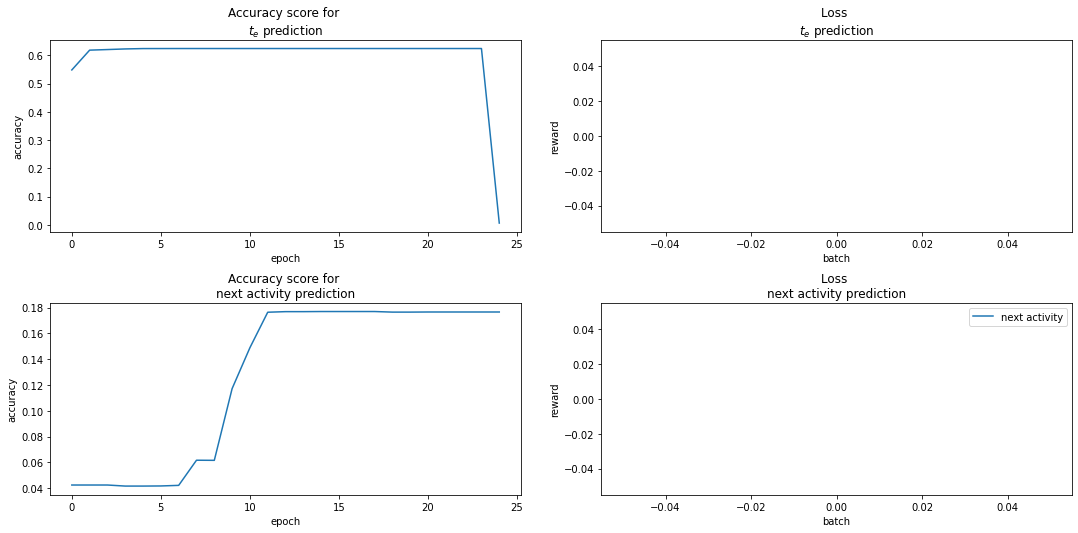

KeyboardInterrupt: 

In [18]:
times = []
for _ in range(1):    
    replay_memory = replay_buffer.ReplayMemory(memory_size, n_traces)
    agency = agencies.Agency(input_size=9 * 2, hidden=hidden, n_lstm=1, te_intervals=te_intervals, ac_learning_rate=1e-3,
                             te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.7)
    wtf = []
    te_rewards = []
    ac_rewards = []
    nn_rewards = []
    losses_ac = []
    losses_te = []
    loc_te_rews = []
    loc_ac_rews = []
    loc_n_ = []
    grad_step_count = 0
    start_t = time.time()
    for epoch in range(100):
        te_rw = 0
        ac_rw = 0
        n = 0
        for _i in range(n_envs):
            print(f'{_i+1}/{n_envs}', end='\r')
            _ = envirs[_i].reset()
            with torch.no_grad():
                _episode_te_rew, _episode_ac_rew, n_ep = utils.play_and_record(agency.te_agent, agency.ac_agent,
                                                                               envirs[_i], replay_memory,
                                                                               process_dvice=cpu, dest_device=cpu,
                                                                               stoch=False
                                                                              )

            if (n_ep < _episode_ac_rew) | (n_ep < _episode_te_rew):
                wtf.append(len(loc_te_rews))
            loc_te_rews.append(_episode_te_rew)
            loc_ac_rews.append(_episode_ac_rew)
            loc_n_.append(n_ep)
            te_rw += _episode_te_rew
            ac_rw += _episode_ac_rew
            n += n_ep
            if replay_memory.is_full():
                agency.to(device)
                ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
                grad_step_count += 1

                losses_ac.append(ep_ac_loss)
                losses_te.append(ep_te_loss)
            # print(ep_te_rew, ep_te_rew, n_samples)

        agency.to(device)
        ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
        te_rewards.append(te_rw / n)
        ac_rewards.append(ac_rw / n)
        nn_rewards.append(n)
        grad_step_count += 1
        if grad_step_count % refresh_every == 0:
            agency.refresh_target(pol_avg)

        display.clear_output(wait=True)
        utils.plot_laerning_process(te_rewards, ac_rewards, losses_te, losses_ac)
        
    times.append(time.time() - start_t)    